# OBJECTIVE : Apply RBF-SVC on Amazon Food Reviews Dataset

# NOTE :-

Since Amazon Fine Food Reviews Dataset have large number of datapoints , so applying SVM on it will be computationally expensive and will take a lot off time during training as its training time complexity is of the order of 'O(n^2)'. Instead I will use "sklearn’s SGDClassifier " with "hinge-loss" for completing this assignment

In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Loading Data

In [3]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364173, 10)


69.25890143662969

In [5]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [6]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [7]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


TIME BASED SPLITTING OF SAMPLE DATASET

In [10]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# (1). Bag of Words (BoW)

In [11]:
#BoW
count_vect = CountVectorizer(min_df = 100) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (254895, 4398)
the number of unique words : 4398


In [12]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

# GridSearchCV Implementation (SGDClassifier with hinge-loss)

In [1]:
# Importing libraries
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_grid_alpha = optimal_alpha
bow_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_grid_test_acc = accuracy_score(Y_test, predictions) * 100

NameError: name 'X_train_vec_standardized' is not defined

In [14]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.100 is 92.206223%

The Test Precision of the SGDClassifier for alpha = 0.100 is 0.932842

The Test Recall of the SGDClassifier for alpha = 0.100 is 0.978055

The Test F1-Score of the SGDClassifier for alpha = 0.100 is 0.954914


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

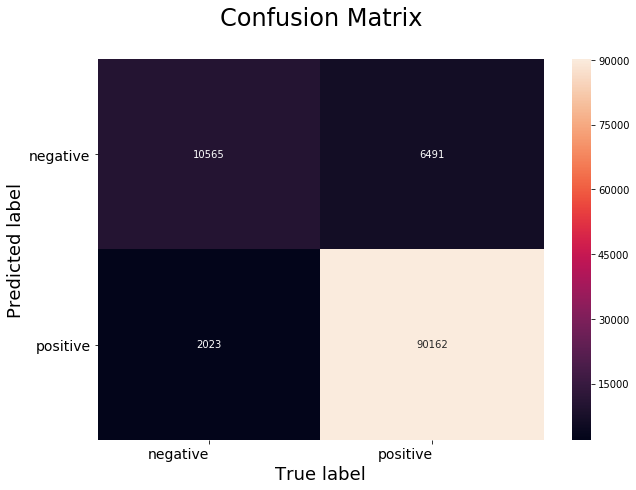

In [15]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# RandomizedSearchCV Implementation (SGDClassifier with hinge-loss)

In [16]:
# Load libraries
from scipy.stats import uniform

# Create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_random_alpha = optimal_alpha
bow_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.05856537013282603, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9223185434040333
The optimal value of alpha(1/C) is :  0.05856537013282603


In [17]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.059 is 92.253824%

The Test Precision of the SGDClassifier for alpha = 0.059 is 0.934739

The Test Recall of the SGDClassifier for alpha = 0.059 is 0.976374

The Test F1-Score of the SGDClassifier for alpha = 0.059 is 0.955103


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

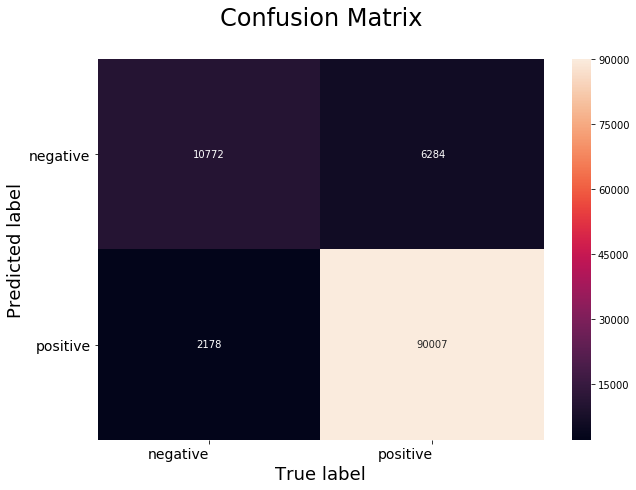

In [18]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (2) TFIDF

In [19]:
tf_idf_vect = TfidfVectorizer(min_df=100)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (254895, 4398)
the number of unique words : 4398


# GridSearchCV Implementation (SGDClassifier with hinge-loss)

In [20]:
Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_grid_alpha = optimal_alpha
tfidf_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.918684376744995
The optimal value of alpha(1/C) is :  0.1


In [21]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.100 is 91.793374%

The Test Precision of the SGDClassifier for alpha = 0.100 is 0.926297

The Test Recall of the SGDClassifier for alpha = 0.100 is 0.980789

The Test F1-Score of the SGDClassifier for alpha = 0.100 is 0.952764


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

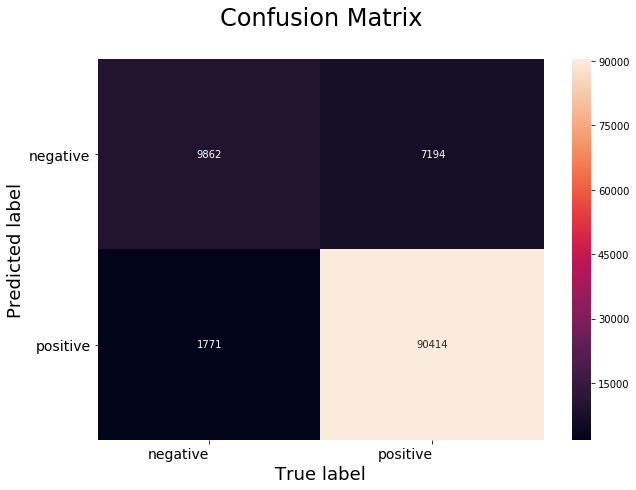

In [22]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# RandomizedSearchCV Implementation (SGDClassifier with hinge-loss)

In [23]:
# Create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_random_alpha = optimal_alpha
tfidf_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.10939671536861173, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9175401177213683
The optimal value of alpha(1/C) is :  0.10939671536861173


In [24]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.109 is 91.782389%

The Test Precision of the SGDClassifier for alpha = 0.109 is 0.926375

The Test Recall of the SGDClassifier for alpha = 0.109 is 0.980550

The Test F1-Score of the SGDClassifier for alpha = 0.109 is 0.952693


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

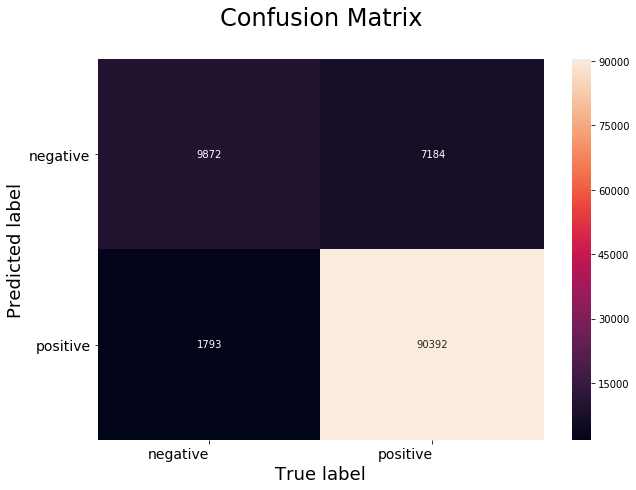

In [25]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Word2Vec

In [26]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  18825


# (3). Avg Word2Vec

In [27]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)

# GridSearchCV Implementation (SGDClassifier with hinge-loss)

In [28]:
Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_grid_alpha = optimal_alpha
avg_w2v_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8994974414368232
The optimal value of alpha(1/C) is :  0.001


In [29]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.001 is 89.912212%

The Test Precision of the SGDClassifier for alpha = 0.001 is 0.917005

The Test Recall of the SGDClassifier for alpha = 0.001 is 0.968075

The Test F1-Score of the SGDClassifier for alpha = 0.001 is 0.941848


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

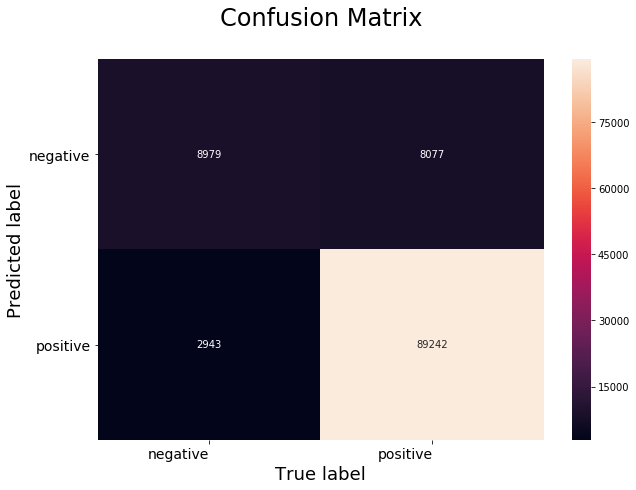

In [30]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# RandomizedSearchCV Implementation (SGDClassifier with hinge-loss)

In [31]:
# Create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_random_alpha = optimal_alpha
avg_w2v_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.10100967404664118, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8790106278778115
The optimal value of alpha(1/C) is :  0.10100967404664118


In [32]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.101 is 87.899232%

The Test Precision of the SGDClassifier for alpha = 0.101 is 0.879783

The Test Recall of the SGDClassifier for alpha = 0.101 is 0.992179

The Test F1-Score of the SGDClassifier for alpha = 0.101 is 0.932607


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

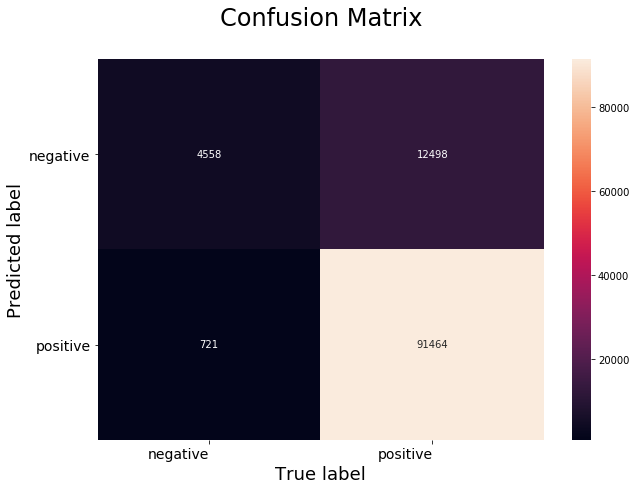

In [33]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (4). TFIDF-Word2Vec

NOTE :- It is taking a lot off time to perform TFIDF-Word2Vec on whole 364K rows of data . So , I am performing it with only 100K rows . Please don't mind because I am unable to perform it with whole data due to poor condition of my laptop . But I am completing all the steps as was asked .

RANDOMLY SAMPLING 100K POINTS OUT OF WHOLE DATASET

In [34]:
# We will collect different 100K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split()) 
    
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)

(100000, 11)


In [35]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1 

In [36]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors) 

# GridSearchCV Implementation (SGDClassifier with hinge-loss)

In [37]:
Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_grid_alpha = optimal_alpha
tfidf_w2v_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.7664666666666666
The optimal value of alpha(1/C) is :  0.001


In [38]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.001 is 77.770000%

The Test Precision of the SGDClassifier for alpha = 0.001 is 0.858522

The Test Recall of the SGDClassifier for alpha = 0.001 is 0.881825

The Test F1-Score of the SGDClassifier for alpha = 0.001 is 0.870018


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

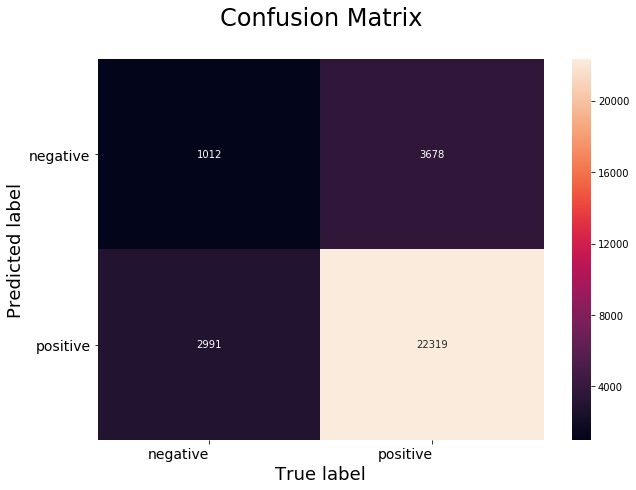

In [39]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# RandomizedSearchCV Implementation (SGDClassifier with hinge-loss)

In [40]:
# Create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_random_alpha = optimal_alpha
tfidf_w2v_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 SGDClassifier(alpha=0.007366780682132035, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.7788333333333334
The optimal value of alpha(1/C) is :  0.007366780682132035


In [41]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.007 is 77.893333%

The Test Precision of the SGDClassifier for alpha = 0.007 is 0.858751

The Test Recall of the SGDClassifier for alpha = 0.007 is 0.883248

The Test F1-Score of the SGDClassifier for alpha = 0.007 is 0.870827


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

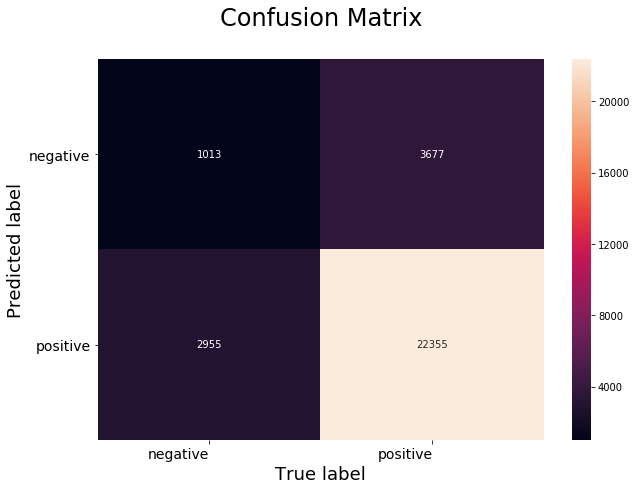

In [42]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Comparing "SGDClassifier with hinge-loss" and "SVC with RBF kernel" on a smaller sample for BoW vectorizer

RANDOMLY SAMPLING 40K POINTS OUT OF WHOLE DATASET

In [43]:
# We will collect different 40K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:40000])
print("Shape of my_final dataframe : ",my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

#BoW (Bag of Words Vectorizer)
count_vect = CountVectorizer(min_df = 100) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

Shape of my_final dataframe :  (40000, 11)
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (28000, 1308)
the number of unique words : 1308


# (a). GridSearchCV Implementation (SGDClassifier with hinge-loss)

In [44]:
Alpha = [0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

# SGDClassifier with Optimal value of alpha i.e.(1/C)
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
predictions = sgd.predict(X_test_vec_standardized)

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9079166666666667
The optimal value of alpha(1/C) is :  0.1


In [45]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the SGDClassifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the SGDClassifier for alpha = %.3f is %f' % (optimal_alpha, acc))


The Test Accuracy of the SGDClassifier for alpha = 0.100 is 90.758333%

The Test Precision of the SGDClassifier for alpha = 0.100 is 0.920393

The Test Recall of the SGDClassifier for alpha = 0.100 is 0.974448

The Test F1-Score of the SGDClassifier for alpha = 0.100 is 0.946649


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

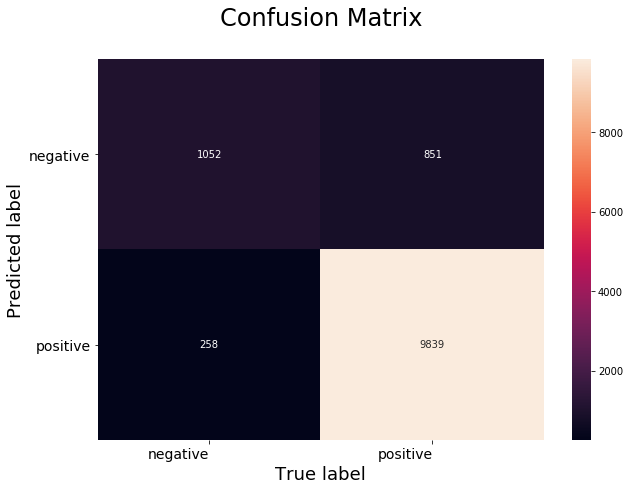

In [46]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

#  (a).GridSearchCV Implementation (SVC with RBF kernel)

In [47]:
from sklearn.svm import SVC

C_range = [1,2,4,8,16,32]

param_grid = {'C': C_range}
model = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C is : ",optimal_C)

# SVC with RBF kernel with Optimal value of C
svc = SVC(C=optimal_C)
svc.fit(X_train_vec_standardized,Y_train)
predictions = svc.predict(X_test_vec_standardized)

Model with best parameters :
 SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of the model :  0.8991666666666667
The optimal value of C is :  4


In [51]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of SVC with RBF kernel for C = %d is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of SVC with RBF kernel for C = %d is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of SVC with RBF kernel for C = %d is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of SVC with RBF kernel for C = %d is %f' % (optimal_C, acc))


The Test Accuracy of SVC with RBF kernel for C = 4 is 89.916667%

The Test Precision of SVC with RBF kernel for C = 4 is 0.911397

The Test Recall of SVC with RBF kernel for C = 4 is 0.974943

The Test F1-Score of SVC with RBF kernel for C = 4 is 0.942100


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

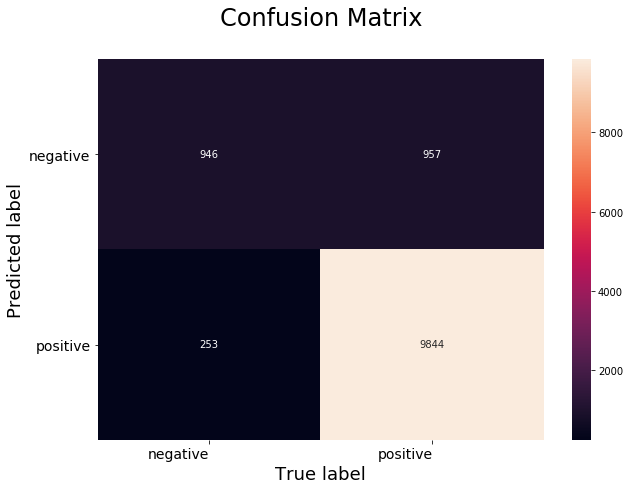

In [52]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# CONCLUSION :-

# (a). Procedure followed :

STEP 1 :- Text Preprocessing

STEP 2:- Time-based splitting of whole dataset into train_data and test_data

STEP 3:- Training the vectorizer on train_data and later applying same vectorizer on both train_data and test_data to transform them into vectors

STEP 4:- Using SGDClassifier with hinge-loss as an estimator in both GridSearchCV and RandomizedSearchCV in order to find optimal value of alpha i.e(1/C)

STEP 5:- Once , we get optimal value of alpha then train SGDClassifier with hinge-loss again with this optimal alpha and make predictions on test_data

STEP 6 :- Evaluate : Accuracy , F1-Score , Precision , Recall

STEP 7:- Draw Seaborn Heatmap for Confusion Matrix .

STEP 8:- Implement SVC with RBF kernel on 40K randomly sampled data from whole dataset for BoW (Bag of Words) vectorizer and compare its result with SGD implementation on same 40K randomly sampled data.

Repeat from STEP 3 to STEP 7 for each of these four vectorizers : Bag Of Words(BoW), TFIDF, Avg Word2Vec and TFIDF Word2Vec

# (b). Table (Model Performances with their hyperparameters :

In [53]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['SGD in GridSearchCV for BoW','SGD in RandomizedSearchCV for BoW','SGD in GridSearchCV for TFIDF',\
         'SGD in RandomizedSearchCV for TFIDF','SGD in GridSearchCV for Avg_Word2Vec',\
         'SGD in RandomizedSearchCV for Avg_Word2Vec','SGD in GridSearchCV for tfidf_Word2Vec',\
         'SGD in RandomizedSearchCV for tfidf_Word2Vec']

# Optimal values of alpha i.e. (1/C)
optimal_alpha = [bow_grid_alpha,bow_random_alpha,tfidf_grid_alpha,tfidf_random_alpha,avg_w2v_grid_alpha,\
                 avg_w2v_random_alpha,tfidf_w2v_grid_alpha,tfidf_w2v_random_alpha]

# Training accuracies
train_acc = [bow_grid_train_acc,bow_random_train_acc,tfidf_grid_train_acc,tfidf_random_train_acc,avg_w2v_grid_train_acc,\
                 avg_w2v_random_train_acc,tfidf_w2v_grid_train_acc,tfidf_w2v_random_train_acc]

# Test accuracies
test_acc = [bow_grid_test_acc,bow_random_test_acc,tfidf_grid_test_acc,tfidf_random_test_acc,avg_w2v_grid_test_acc,\
                 avg_w2v_random_test_acc,tfidf_w2v_grid_test_acc,tfidf_w2v_random_test_acc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha(1/C)",optimal_alpha)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+----------------------------------------------+----------------------+-------------------+-------------------+
| S.NO. |                    MODEL                     |   Best Alpha(1/C)    | Training Accuracy |   Test Accuracy   |
+-------+----------------------------------------------+----------------------+-------------------+-------------------+
|   1   |         SGD in GridSearchCV for BoW          |         0.1          | 92.20073049496068 |  92.2062229382741 |
|   2   |      SGD in RandomizedSearchCV for BoW       | 0.05856537013282603  | 92.23185434040333 | 92.25382411365696 |
|   3   |        SGD in GridSearchCV for TFIDF         |         0.1          |  91.8684376744995 | 91.79337428254959 |
|   4   |     SGD in RandomizedSearchCV for TFIDF      | 0.10939671536861173  | 91.75401177213683 | 91.78238939592278 |
|   5   |     SGD in GridSearchCV for Avg_Word2Vec     |        0.001         | 89.94974414368232 | 89.91221244770736 |
|   6   |  SGD in RandomizedSearchCV for